## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    \Delta u = 1\qquad &u\in\Omega\\
    u = 0\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|x^2+y^2 < 1\}$

The exact solution to this problem is $$u = \frac{1}{4}(x^2+y^2-1).$$

In [1]:
% matplotlib inline
import torch 
import torch.nn.functional as F
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
    
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [2]:
def draw_graph(mod):
    points = np.arange(-1, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [3]:
def cal_loss(mod):
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
            #?????????
            if re[0] ** 2 + re[1] ** 2 < 1 : 
                mmm += abs(z[i, j])
                t = t + 1
    
    return mmm / t

In [4]:
#U_groundtruth = 1/4*(x^2+y^2)-1/4
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    #re = 0
    re = (t[0] ** 2 + t[1] ** 2 - 1).item() / 4
    return re

def on_sample(m):
    theta = np.random.rand() * 2 * pi
    a = np.linspace(0, 2*pi, 100)
    
    re = np.zeros(m)
    re[0] = cos(theta)
    re[1] = sin(theta)
    re = torch.tensor(re, requires_grad=True)
    return re

In [5]:
"""
Train with the grid
"""
gamma = 100
model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 1
points = np.arange(-1, 1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()
                
lr1 = 0.01
lr2 = 0.003
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr1)
optimizer2 = torch.optim.Adam(model.parameters(), lr=lr2)
ccc = 1
for k in range(400):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (model(x_input_1) + model(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (model(x_input_2) + model(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    
    grid = np.linspace(0, 2*pi, 200)
    n2 = 1
    for i in range(200):
        if i < 199:
            grid_i_1 = grid[i+1]
        else:
            grid_i_1 = grid[0]
        th = (grid[i] + grid_i_1) / 2
        x1 = np.zeros(m)
        x1[0] = cos(th)
        x1[1] = sin(th)
        x1 = torch.tensor(x1).float()
        yy = model(x1)
        t = floor(abs(yy)*100)
        for theta in np.linspace(grid[i], grid_i_1, t):
            x_input = np.zeros(m)
            x_input[0] = cos(theta)
            x_input[1] = sin(theta)
            x_input = torch.tensor(x_input).float()
            y = model(x_input)
            regularization += y**2 
            n2 = n2 + 1
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.015
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    cal_l = cal_loss(model)
    print(k, " loss to real solution: ", cal_l)
    #???? 
    if cal_l < ccc:
        mod = model
        ccc = cal_l
    
    loss += regularization
    
    #and step the optimizer
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    loss.backward()
    if k < 150:
        optimizer1.step()
    else:
        optimizer2.step()

0  epoch, loss:  -0.22560187
0  epoch, regularization loss:  0.16618122
0  loss to real solution:  0.18551948996793807
1  epoch, loss:  -0.23053798
1  epoch, regularization loss:  0.14460298
1  loss to real solution:  0.1842542877592075
2  epoch, loss:  -0.24529469
2  epoch, regularization loss:  0.13842998
2  loss to real solution:  0.19784546017838447
3  epoch, loss:  -0.26498455
3  epoch, regularization loss:  0.14284846
3  loss to real solution:  0.21949218361707362
4  epoch, loss:  -0.28503224
4  epoch, regularization loss:  0.15385613
4  loss to real solution:  0.24295733825570134
5  epoch, loss:  -0.2989239
5  epoch, regularization loss:  0.16328992
5  loss to real solution:  0.259534235548743
6  epoch, loss:  -0.302728
6  epoch, regularization loss:  0.16506524
6  loss to real solution:  0.2639482296318103
7  epoch, loss:  -0.29910427
7  epoch, regularization loss:  0.16063425
7  loss to real solution:  0.25939808694496025
8  epoch, loss:  -0.2909909
8  epoch, regularization lo

68  epoch, loss:  -0.15218604
68  epoch, regularization loss:  0.05716701
68  loss to real solution:  0.11632247946749165
69  epoch, loss:  -0.15344244
69  epoch, regularization loss:  0.05941464
69  loss to real solution:  0.1190633685364601
70  epoch, loss:  -0.14596696
70  epoch, regularization loss:  0.052847
70  loss to real solution:  0.11046534445699772
71  epoch, loss:  -0.14051071
71  epoch, regularization loss:  0.048826646
71  loss to real solution:  0.10512581237259404
72  epoch, loss:  -0.14488661
72  epoch, regularization loss:  0.053681605
72  loss to real solution:  0.11291476283617723
73  epoch, loss:  -0.15226272
73  epoch, regularization loss:  0.06252178
73  loss to real solution:  0.12373225989449065
74  epoch, loss:  -0.13957758
74  epoch, regularization loss:  0.049791537
74  loss to real solution:  0.10744986574941126
75  epoch, loss:  -0.13117924
75  epoch, regularization loss:  0.041924883
75  loss to real solution:  0.09687464901872002
76  epoch, loss:  -0.14

134  epoch, loss:  -0.08842676
134  epoch, regularization loss:  0.026191046
134  loss to real solution:  0.037385961318514294
135  epoch, loss:  -0.078086935
135  epoch, regularization loss:  0.016793111
135  loss to real solution:  0.02517391805384314
136  epoch, loss:  -0.08786003
136  epoch, regularization loss:  0.025986997
136  loss to real solution:  0.039455975985986956
137  epoch, loss:  -0.08091525
137  epoch, regularization loss:  0.019210137
137  loss to real solution:  0.03140655169149682
138  epoch, loss:  -0.08061305
138  epoch, regularization loss:  0.018572511
138  loss to real solution:  0.03210086643408344
139  epoch, loss:  -0.09558971
139  epoch, regularization loss:  0.03604957
139  loss to real solution:  0.050916537135551936
140  epoch, loss:  -0.06388926
140  epoch, regularization loss:  0.009665266
140  loss to real solution:  0.01234826928357982
141  epoch, loss:  -0.081172116
141  epoch, regularization loss:  0.021251492
141  loss to real solution:  0.029252

199  epoch, loss:  -0.0621505
199  epoch, regularization loss:  0.009760746
199  loss to real solution:  0.01690665389276389
200  epoch, loss:  -0.060922045
200  epoch, regularization loss:  0.008940946
200  loss to real solution:  0.015992873188383654
201  epoch, loss:  -0.06088168
201  epoch, regularization loss:  0.0089315865
201  loss to real solution:  0.015469693424617313
202  epoch, loss:  -0.060262762
202  epoch, regularization loss:  0.008419209
202  loss to real solution:  0.01449660686913788
203  epoch, loss:  -0.059444908
203  epoch, regularization loss:  0.0075882543
203  loss to real solution:  0.01355746655123021
204  epoch, loss:  -0.058925696
204  epoch, regularization loss:  0.0070782965
204  loss to real solution:  0.0131579493652202
205  epoch, loss:  -0.059069425
205  epoch, regularization loss:  0.007174929
205  loss to real solution:  0.013262771974614127
206  epoch, loss:  -0.059096213
206  epoch, regularization loss:  0.0070413533
206  loss to real solution:  0

264  epoch, loss:  -0.047471076
264  epoch, regularization loss:  0.0045574824
264  loss to real solution:  0.015286813754935782
265  epoch, loss:  -0.04326871
265  epoch, regularization loss:  0.0
265  loss to real solution:  0.02026562326303254
266  epoch, loss:  -0.047231283
266  epoch, regularization loss:  0.0061119227
266  loss to real solution:  0.015316199550099737
267  epoch, loss:  -0.04888606
267  epoch, regularization loss:  0.0067625726
267  loss to real solution:  0.013785423077762735
268  epoch, loss:  -0.04513468
268  epoch, regularization loss:  0.0
268  loss to real solution:  0.017458717173318813
269  epoch, loss:  -0.05051475
269  epoch, regularization loss:  0.0081906775
269  loss to real solution:  0.01248443108279609
270  epoch, loss:  -0.048729774
270  epoch, regularization loss:  0.006993528
270  loss to real solution:  0.014032001876754421
271  epoch, loss:  -0.044135828
271  epoch, regularization loss:  0.0
271  loss to real solution:  0.018729299192834944
27

332  epoch, loss:  -0.013944179
332  epoch, regularization loss:  0.0
332  loss to real solution:  0.08580300806419645
333  epoch, loss:  -0.016102118
333  epoch, regularization loss:  0.012624639
333  loss to real solution:  0.08064891220576512
334  epoch, loss:  -0.014478131
334  epoch, regularization loss:  0.0
334  loss to real solution:  0.08331421588203149
335  epoch, loss:  -0.014363002
335  epoch, regularization loss:  0.0
335  loss to real solution:  0.08405121394675648
336  epoch, loss:  -0.014046274
336  epoch, regularization loss:  0.0
336  loss to real solution:  0.08304793222732486
337  epoch, loss:  -0.01491127
337  epoch, regularization loss:  0.0
337  loss to real solution:  0.08061368759038746
338  epoch, loss:  -0.017259995
338  epoch, regularization loss:  0.0
338  loss to real solution:  0.07647125042423943
339  epoch, loss:  -0.019696184
339  epoch, regularization loss:  0.0
339  loss to real solution:  0.07055929404171335
340  epoch, loss:  -0.023831256
340  epoc

In [24]:
mmmm = model

In [ ]:
# Calculate time for grid method
start = time.time()
for k in range(10):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
stop = time.time()
print(stop - start)

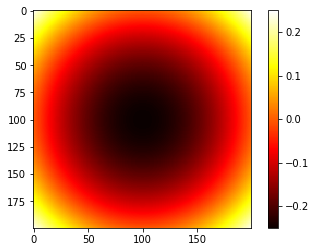

0.098049999999999998

In [35]:
#torch.save(model.state_dict(), '2/model.pkl')
draw_graph()
cal_loss()